In [1]:
import os
import re
import math
import jieba
import torch
import collections
import numpy as np

from torch import nn
# from d2l import torch as d2l
from torch.utils import data


# Eng-Zh dataset
with open(os.path.join('/Users/yyh/Desktop/d2l/data/cmn-eng','cmn_simple.txt'), 'r') as f:
    raw_text = f.read()
    
# # Eng-fras dataset
# with open(os.path.join('/Users/yyh/Desktop/d2l/data/fra-eng','fra.txt'), 'r') as f:
#     raw_text = f.read()

In [8]:
# 删除字符串中，两个指定字符之间的内容
def deletebystartend(text, start, end):    
    # 找出两个字符串在原始字符串中的位置，开始位置是：开始始字符串的最左边第一个位置，结束位置是：结束字符串的最右边的第一个位置
    x1 = text.index(start) 
#     x2 = text.index(end) + len(end)  # s.index()函数算出来的是字符串的最左边的第一个位置
    # 找出两个字符串之间的内容
#     x3 = text[x1:x2]
    x3 = text[x1:]
    # 将内容替换为控制符串
    result = text.replace(x3, "")
    return result

# Corpus 预处理
def preprocess(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 使⽤空格替换不间断空格
    # 使⽤⼩写字⺟替换⼤写字⺟
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点之间加入空格
    out = [' ' + char if i>0 and no_space(char, text[i-1]) else char 
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize(text, num_examples=None):
    """Tokenize the dataset"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        # num_examples limited the number of sentences contained in the set
        if num_examples and i > num_examples:
            # break will break the for loop here
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            # For Chinese
            target.append(jieba.lcut(parts[1]))
#             # For fra 
#             target.append(parts[1].split(' '))
    return source, target

def count_corpus(tokens):
    """Count tokens frequencies in corpus"""
    # Here "tokens" could be 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """Defined in :numref:`sec_text_preprocessing`"""
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        # Sort函数详情见 印象笔记，key=lambda x: x[1] 指的是按照tuple里第二位的元素大小排序
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences"""
    if len(line) > num_steps:
        return line[:num_steps] # Truncate
    return line + [padding_token] * (num_steps - len(line)) # Pad

def build_array(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len


def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator.
    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_data(raw_text, batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess(raw_text)
    source, target = tokenize(text, num_examples)
    src_vocab = Vocab(source, min_freq=1, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=1, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab



In [9]:
# Test Vocab
train_iter, src_vocab, tgt_vocab = load_data(raw_text, batch_size=2, num_steps=8)

len(src_vocab), len(tgt_vocab)

(415, 515)

In [10]:
src_vocab['<unk>'], tgt_vocab['<pad>'], src_vocab['<bos>'], tgt_vocab['<eos>']

(0, 1, 2, 3)

In [11]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer

In [12]:
class PositionalEncoding(nn.Module):
    '''Position Encoding'''
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough 'P'
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1,1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        # 'X'的形状：(batch_size,num_steps,embed_size)
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [96]:
class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""
    
    def __init__(self, 
                 src_num_tokens, 
                 tgt_num_tokens, 
                 emb_size, 
                 num_heads, 
                 num_encoder_layers, 
                 num_decoder_layers, 
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(TransformerModel, self).__init__()
        
        # INFO
        self.model_type = "Transformer"
        self.dim_model = emb_size
        
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.src_embedding = nn.Embedding(src_num_tokens, emb_size)
        self.tgt_embedding = nn.Embedding(tgt_num_tokens, emb_size)
        
        # batch_first: If ``True``, then the input and output tensors are provided
        # as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        self.transformer = nn.Transformer(
            d_model=emb_size, 
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True)
                
        self.out = nn.Linear(emb_size, tgt_num_tokens)

        
    def forward(self, 
                src, 
                tgt, 
                src_mask=None,
                tgt_mask=None, 
                src_pad_mask=None, 
                tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)
        # Embedding + positional encoding -- 
        # Out size = (batch_size, sequence length, dim_model)
        src = self.src_embedding(src) * math.sqrt(self.dim_model)
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)
        
        # Transformer blocks -- Out size = (batch_size, sequence length, dim_model)
        transformer_out = self.transformer(src, tgt, 
                                           src_mask=src_mask, tgt_mask=tgt_mask,
                                           src_key_padding_mask=src_pad_mask,
                                           tgt_key_padding_mask=tgt_pad_mask)
        
        # Final out size = (batch_size, sequence length, num_tokens)
        out = self.out(transformer_out)
        
        return out
    
    
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) ## Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zerso to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        return mask
    
    def get_padding_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
    # Create the mask matrix for source or target input
    # shape of X is (batch_size, sequence length)
    # shape of mask matrix is (batch_size, sequence length)
        return (matrix == pad_token)
    
    def encode(self, src: Tensor, src_mask: Tensor):
        src = self.src_embedding(src) * math.sqrt(self.dim_model)
        src = self.positional_encoding(src)
        return self.transformer.encoder(src, src_mask)
    
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.dim_model)
        tgt = self.positional_encoding(tgt)
        return self.transformer.decoder(tgt, memory, tgt_mask)

In [97]:
# # Test
# train_iter, src_vocab, tgt_vocab = load_data(raw_text, batch_size=2, num_steps=8)

# len(src_vocab), len(tgt_vocab)

# Approach By Mu Li's Book

In [61]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 64
NHEAD = 8
FFN_HID_DIM = 32
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

NUM_STEPS = 10

train_iter, src_vocab, tgt_vocab = load_data(raw_text, 
                                             batch_size=BATCH_SIZE, 
                                             num_steps=NUM_STEPS)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = TransformerModel(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMB_SIZE, NHEAD, 
                       NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, FFN_HID_DIM)

for p in net.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
# net = net.to(DEVICE)

# loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# optimizer = torch.optim.Adam(net.parameters(), 
#                              lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [62]:
# for X, X_valid_len, Y, Y_valid_len in train_iter:
#     print('X:', X.type(torch.int32))
#     print('Size', X.shape)
#     print('valid lengths for X:', X_valid_len)
#     print('Y:', Y.type(torch.int32))
#     print('Size', Y.shape)
#     print('valid lengths for Y:', Y_valid_len)
    
#     bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
#                    device=device).reshape(-1, 1)
#     print(bos)
#     dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
#     print(dec_input)
#     print(dec_input.shape)
#     break

In [63]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.
       Defined in :numref:`sec_seq2seq_decoder`"""

    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            
            # Get mask to mask out the next words
            sequence_length = dec_input.size(1)
            tgt_mask = net.get_tgt_mask(sequence_length).to(device)
            
            # Get mask of the src & tgt padding
            src_pad_mask = net.get_padding_mask(X, 1)
            tgt_pad_mask = net.get_padding_mask(Y, 1)
            
            Y_hat = net(X, dec_input, 
                        src_mask=None, 
                        tgt_mask=tgt_mask, 
                        src_pad_mask=src_pad_mask, 
                        tgt_pad_mask=tgt_pad_mask)

            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.012, 5345.8 tokens/sec on cpu


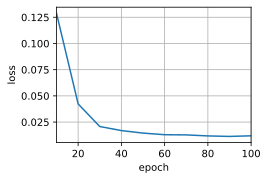

In [64]:
from d2l import torch as d2l

lr, num_epochs, device = 0.005, 100, d2l.try_gpu()

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [65]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence.

    Defined in :numref:`sec_seq2seq_training`"""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)

    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y = net(enc_X, dec_X)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [66]:
#@tab mxnet, pytorch
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
zhs = ['走 。', '我 输了 。', '他 冷静 了 。', '我 在 家里 。']
for eng, fra in zip(engs, zhs):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, 10, device, False)
    print(f'{eng} => {translation}, ', 
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => 走 吧 走 吧 走 吧 走 吧 走 吧,  bleu 0.000
i lost . => 我 迷失 了 。,  bleu 0.000
he's calm . => 他 很酷 。,  bleu 0.000
i'm home . => 我 在家 。,  bleu 0.000


# Another Traning Approach

In [205]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 32
NHEAD = 4
FFN_HID_DIM = 32
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

NUM_STEPS = 10

train_iter, src_vocab, tgt_vocab = load_data(raw_text, 
                                             batch_size=BATCH_SIZE, 
                                             num_steps=NUM_STEPS)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = TransformerModel(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMB_SIZE, NHEAD, 
                       NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, FFN_HID_DIM)

for p in net.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
net = net.to(DEVICE)

loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(net.parameters(), lr=0.005, betas=(0.9, 0.98), eps=1e-9)

In [206]:
# for batch in train_iter:
#     X, X_valid_len, Y, Y_valid_len = [x.to(DEVICE) for x in batch]
#     bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], 
#                        device=DEVICE).reshape(-1, 1)
#     dec_input = d2l.concat([bos, Y[:, :-1]], 1)

#     # Get mask to mask out the next words
#     sequence_length = dec_input.size(1)
#     tgt_mask = net.get_tgt_mask(sequence_length).to(device)

#     # Get mask of the src & tgt padding
#     src_pad_mask = net.get_padding_mask(X, 1)
#     tgt_pad_mask = net.get_padding_mask(Y, 1)

#     Y_hat = net(X, dec_input, 
#                 src_mask=None, 
#                 tgt_mask=tgt_mask, 
#                 src_pad_mask=src_pad_mask, 
#                 tgt_pad_mask=tgt_pad_mask)
#     print(Y_hat.shape)
#     print(Y_hat.reshape(-1, Y_hat.shape[-1]).shape)
#     print(Y.reshape(-1).shape)
#     break

In [207]:
# memory = net.encode(X, src_mask=None)
# out = net.decode(Y, memory, tgt_mask)
# print(out.shape, out[:,0].shape)
# print(out, out[:,0])

# prob = net.out(out)
# prob.shape

In [208]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    
    for batch in train_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(DEVICE) for x in batch]
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], 
                           device=DEVICE).reshape(-1, 1)
        dec_input = d2l.concat([bos, Y[:, :-1]], 1)
        
        # Get mask to mask out the next words
        sequence_length = dec_input.size(1)
        tgt_mask = net.get_tgt_mask(sequence_length).to(device)

        # Get mask of the src & tgt padding
        src_pad_mask = net.get_padding_mask(X, 1)
        tgt_pad_mask = net.get_padding_mask(Y, 1)
        
        # Y_hat size = (batch_size, sequence length, num_tokens)
        Y_hat = net(X, dec_input, 
                    src_mask=None, 
                    tgt_mask=tgt_mask, 
                    src_pad_mask=src_pad_mask, 
                    tgt_pad_mask=tgt_pad_mask)
        
        optimizer.zero_grad()
        
        loss = loss_fn(Y_hat.reshape(-1, Y_hat.shape[-1]), Y.reshape(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item()
        
    return losses / len(train_iter)


NUM_EPOCHS = 80

from timeit import default_timer as timer

for epoch in range(1, NUM_EPOCHS):
    start_time = timer()
    train_loss = train_epoch(net, optimizer)
    end_time = timer()
    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "
           f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.529, Epoch time = 0.267s
Epoch: 2, Train loss: 4.319, Epoch time = 0.259s
Epoch: 3, Train loss: 3.645, Epoch time = 0.261s
Epoch: 4, Train loss: 3.222, Epoch time = 0.260s
Epoch: 5, Train loss: 2.930, Epoch time = 0.262s
Epoch: 6, Train loss: 2.710, Epoch time = 0.257s
Epoch: 7, Train loss: 2.517, Epoch time = 0.260s
Epoch: 8, Train loss: 2.326, Epoch time = 0.258s
Epoch: 9, Train loss: 2.167, Epoch time = 0.257s
Epoch: 10, Train loss: 2.037, Epoch time = 0.257s
Epoch: 11, Train loss: 1.898, Epoch time = 0.256s
Epoch: 12, Train loss: 1.794, Epoch time = 0.256s
Epoch: 13, Train loss: 1.683, Epoch time = 0.257s
Epoch: 14, Train loss: 1.576, Epoch time = 0.257s
Epoch: 15, Train loss: 1.473, Epoch time = 0.256s
Epoch: 16, Train loss: 1.368, Epoch time = 0.258s
Epoch: 17, Train loss: 1.266, Epoch time = 0.257s
Epoch: 18, Train loss: 1.187, Epoch time = 0.257s
Epoch: 19, Train loss: 1.114, Epoch time = 0.256s
Epoch: 20, Train loss: 1.028, Epoch time = 0.256s
Epoch: 21

In [209]:
def greedy_decode(model, src, max_len, start_symbol, src_mask=None,):
    src = src.to(DEVICE)
#     src_mask = src_mask.to(DEVICE)
    
    memory = model.encode(src, src_mask)
    ys = torch.ones(1,1).fill_(start_symbol).type(torch.long).to(DEVICE)
    
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = net.get_tgt_mask(ys.size(1)).to(DEVICE)
        
        out = net.decode(ys, memory, tgt_mask)
#         # 此处time step应该是1，而out的输出是(N,T,E)，T=1
#         print(out.shape[1])
        # out[:, -1]改out的输出为 (N,E)
        prob = net.out(out[:, -1])
        # torch.max return two tensors: values, indices
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys,
                       torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    
    return ys       

In [210]:
def translate(model: nn.Module, src_sentence: str):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=DEVICE)
    src_tokens = truncate_pad(src_tokens, NUM_STEPS, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    
    tgt_tokens = greedy_decode(
        net,  enc_X, max_len=enc_X.shape[0] + 5, 
        start_symbol=BOS_IDX).flatten()
    return " ".join(tgt_vocab.to_tokens(tgt_tokens.tolist())).replace("<bos>", "").replace("<eos>", "")

In [211]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
zhs = ['走 ！', '我 输了 。', '他 很 冷静 。', '我 回家 了 。']

for eng, zhs in zip(engs, zhs):
    translation = translate(net, eng)
    print(f'{eng} => {translation}, ', 
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . =>  回家吧 。 ,  bleu 0.000
i lost . =>  我 迷失 了 。 ,  bleu 0.000
he's calm . =>  他 很 坐 。 ,  bleu 0.000
i'm home . =>  我 在 家里 。 ,  bleu 0.719
